# German Credit Data Analysis

This notebook contains the analysis of Credit Data. Includes EDA, feature selection using Gerneralised Linear Model (GLM) and its prediction using Logistic Regression and Decision Tree with different evaluation metrics.
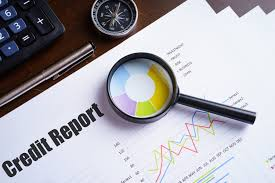

In [ ]:
import os
import pandas as pd
import numpy as np


import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

In [ ]:
black_red = [
    '#1A1A1D', '#4E4E50', '#C5C6C7', '#6F2232', '#950740', '#C3073F'
]
plt.style.use('fivethirtyeight')

In [ ]:
df = pd.read_csv('../input/german-credit/german_credit_data.csv')
df.head(10)

**Data Analysis**

In [ ]:
df.info()

In [ ]:
df.columns

In [ ]:
df.describe()

# Exploratory Data Analysis

In [ ]:
fig = plt.figure(constrained_layout = True, figsize = (20,9))

#create grid

grid = gridspec.GridSpec(ncols = 4, nrows = 2, figure = fig)

ax1 = fig.add_subplot(grid[0, :2])
ax1.set_title('Checking Status')


sns.countplot(df['checking_status'],
             alpha = 0.9,
             ax = ax1,
             color = '#C3073F')

ax1.legend()

ax2 = fig.add_subplot(grid[0, 2:])
ax2.set_title('Purpose Distribution')
sns.countplot(df['purpose'],
             alpha = 0.9,
             ax = ax2, 
             color = '#C3073F')
ax2.legend()
plt.xticks(rotation = 50)
plt.show()

In [ ]:
fig = plt.figure(constrained_layout = True, figsize = (15,9))

#create grid

grid = gridspec.GridSpec(ncols = 1, nrows = 3, figure = fig)
ax1 = fig.add_subplot(grid[0, :])

sns.distplot(df.duration, ax = ax1, color = '#950740')
ax1.set_title('Time Distribution')

ax2 = fig.add_subplot(grid[1, :])
sns.distplot(df.credit_amount, ax = ax2, color = '#C3073F')
ax2.set_title('Credit Amount Distribution')


ax3 = fig.add_subplot(grid[2, :])
sns.distplot(df.age, ax = ax3, color = '#6F2232')
ax3.set_title('Age Distribution')
plt.show()

**Sunburst Chart with Checking Status > Class > Credit History**

In [ ]:
black_red1 = [
    '#1A1A1D', '#950740', '#C3073F'
]
fig = px.sunburst(data_frame = df,
                 path = [ 'checking_status','class','credit_history'],
                 color = 'class',
                 color_discrete_sequence = black_red1,
                 maxdepth = -1,
                 title = 'Sunburst Chart Checking Status > Class > Credit History')
fig.update_traces(textinfo = 'label+percent parent')
fig.update_layout(margin=dict(t=0, l=0, r=0, b=0))
fig.show()

**Encoding categorical variables using LabelEncoder**

In [ ]:

categorical_feature_mask = df.dtypes==object
categorical_cols = df.columns[categorical_feature_mask].tolist()
print(categorical_cols)

In [ ]:

le = LabelEncoder()
df[categorical_cols] = df[categorical_cols].apply(lambda col: le.fit_transform(col))
df.head(10)

In [ ]:
df_new = df.rename(columns={'class': 'label'})

# Correlation between variables. 

In [ ]:
plt.rcParams['figure.figsize']=35,35
g = sns.heatmap(df_new.corr(),annot=True, fmt = ".1f", cmap = "coolwarm")

In [ ]:
fig = plt.figure(constrained_layout = True, figsize = (20,6))

#create grid

grid = gridspec.GridSpec(ncols = 6, nrows = 1, figure = fig)

ax1 = fig.add_subplot(grid[0, :2])

sns.scatterplot(x=df_new['duration'] , y =df_new['credit_amount'], palette = [black_red[1], black_red[4]], ax = ax1, hue = df_new['label'],
               style = df_new['label'])
ax1.set_title('Correlation between Duration and Credit Amount')
ax1.legend(loc = 'lower right')

In [ ]:
formula = 'label ~ checking_status+duration+credit_history+purpose+credit_amount+savings_status+employment+installment_commitment+personal_status+other_parties+residence_since+property_magnitude+age+other_payment_plans+housing+existing_credits+job+num_dependents+own_telephone+foreign_worker'
model_glm = smf.glm(formula = formula, data=df_new, family=sm.families.Binomial())
result = model_glm.fit()
print(result.summary())

Based on GLM Results only 7 features are selected with p value < 0.05. 

In [ ]:
formula2 = 'label ~ checking_status+duration+purpose+credit_amount+savings_status+installment_commitment+personal_status'
model_glm2 = smf.glm(formula = formula2, data=df_new, family=sm.families.Binomial())
result2 = model_glm2.fit()
print(result2.summary())

In [ ]:
X = df_new[['checking_status', 'duration', 'purpose', 'credit_amount', 'savings_status', 'installment_commitment', 'personal_status']]
Y = df_new['label']
print(X.shape, Y.shape)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.25, random_state=42)

# Logistic Regression

In [ ]:
logreg = sm.Logit(y_train, sm.add_constant(X_train)).fit()
print (logreg.summary())


In [ ]:
# instantiate model
logreg = LogisticRegression()

# fit model
logreg.fit(X_train, y_train)
y_pred_train = logreg.predict(X_train)
y_pred_class = logreg.predict(X_test)

In [ ]:
def acc_val(TP, TN, FP, FN, data):    
    accuracy = (TP + TN) / float(TP + TN + FP + FN)
    recall = TP / float(FN + TP)
    specificity = TN / (TN + FP)
    false_positive_rate = FP / float(TN + FP)
    precision = TP / float(TP + FP)
    F1 = 2 * (precision * recall) / (precision + recall)
    print('The values for {} are:'.format(data))
    print('Accuracy: {} ,Recall: {} , Specificity: {} , False Positive Rate: {} , Precision: {}, F1 Score: {}'.format(accuracy, recall, specificity, false_positive_rate,
                                                                                                                   precision, F1))

# Confusion Metrics 

In [ ]:
confusion = metrics.confusion_matrix(y_test, y_pred_class)
print(confusion)
TP1 = confusion[1, 1]
TN1 = confusion[0, 0]
FP1 = confusion[0, 1]
FN1 = confusion[1, 0]
acc_val(TP1, TN1, FP1, FN1, 'Test Data')

In [ ]:
confusion = metrics.confusion_matrix(y_train, y_pred_train)
print(confusion)
TP2 = confusion[1, 1]
TN2 = confusion[0, 0]
FP2 = confusion[0, 1]
FN2 = confusion[1, 0]
acc_val(TP2, TN2, FP2, FN2, 'Train Data')

# ROC_AUC

In [ ]:
y_pred_prob = logreg.predict_proba(X_test)[:, 1]
y_pred_prob_train = logreg.predict_proba(X_train)[:, 1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, y_pred_prob)
fpr2, tpr2, thresholds2 = metrics.roc_curve(y_train, y_pred_prob_train)

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = metrics.roc_curve(y_test, random_probs, pos_label=1)
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Test Data')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Train_Data')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue', label = 'Threshold')
# title
plt.title('ROC curve for Logistic Regression')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

In [ ]:
print('AUC socre for Test data: {}'.format(metrics.roc_auc_score(y_test, y_pred_prob)))
print('AUC socre for Train data: {}'.format(metrics.roc_auc_score(y_train, y_pred_prob_train)))

# In Sample Mis-Classification

In [ ]:
def insample(y_pred_prob, y_test):
    k = []
    threshold = 0.2667
    y = y_pred_prob>0.2667
    for i in range(0,250):
        if y[i]!=y_test[i]:
            k.append(int(1))
        else:
            k.append(int(0))
    return reduce(lambda a, b: a + b, k) / len(k) 
                

In [ ]:
from functools import reduce
mis_error1 = insample(y_pred_prob, list(y_test))

print('In Sample Misclassification Rate: {}'.format(mis_error1))

# Decision Tree

In [ ]:
tree_model = DecisionTreeClassifier(max_depth = 20)
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)

In [ ]:
from sklearn import tree
text_representation = tree.export_text(tree_model)
print(text_representation)

In [ ]:
features = ['checking_status', 'duration', 'purpose', 'credit_amount', 'savings_status', 'installment_commitment', 'personal_status']
labels = ['good', 'bad']

In [ ]:

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(tree_model,
                feature_names = features, 
               class_names=labels,
               filled = True)

# Confusion Metrics

In [ ]:
tree_confusion = metrics.confusion_matrix(y_test, y_pred_tree)
print(tree_confusion)
TP3 = tree_confusion[1, 1]
TN3 = tree_confusion[0, 0]
FP3 = tree_confusion[0, 1]
FN3 = tree_confusion[1, 0]
acc_val(TP3, TN3, FP3, FN3, 'Test Data')

In [ ]:
y_pred_train_tree = tree_model.predict(X_train)
tree_confusion = metrics.confusion_matrix(y_train, y_pred_train_tree)
print(tree_confusion)
TP4 = tree_confusion[1, 1]
TN4 = tree_confusion[0, 0]
FP4 = tree_confusion[0, 1]
FN4 = tree_confusion[1, 0]
acc_val(TP4, TN4, FP4, FN4, 'Train Data')


# ROC_AUC

In [ ]:
y_pred_prob_tree = tree_model.predict_proba(X_test)[:, 1]
y_pred_prob_train_tree = tree_model.predict_proba(X_train)[:, 1]
fpr3, tpr3, thresholds3 = metrics.roc_curve(y_test, y_pred_prob_tree)
fpr4, tpr4, thresholds4 = metrics.roc_curve(y_train, y_pred_prob_train_tree)

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = metrics.roc_curve(y_test, random_probs, pos_label=1)
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr3, tpr3, linestyle='--',color='orange', label='Test Data')
plt.plot(fpr4, tpr4, linestyle='--',color='green', label='Train_Data')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue', label = 'Threshold')
# title
plt.title('ROC curve for Decision Tree')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

In [ ]:
print('AUC socre for Test data: {}'.format(metrics.roc_auc_score(y_test, y_pred_prob_tree)))
print('AUC socre for Train data: {}'.format(metrics.roc_auc_score(y_train, y_pred_prob_train_tree)))

# In sample Misclassification Rate

In [ ]:
from functools import reduce
mis_error2 = insample(y_pred_prob_tree, list(y_test))
print('In Sample Misclassification Rate: {}'.format(mis_error2))


# Comparison

In [ ]:
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = metrics.roc_curve(y_test, random_probs, pos_label=1)
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(fpr3, tpr3, linestyle='--',color='green', label='Decision Tree')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue', label = 'Threshold')
# title
plt.title('ROC curve for Test Data')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

In [ ]:
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = metrics.roc_curve(y_test, random_probs, pos_label=1)
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr2, tpr2, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(fpr4, tpr4, linestyle='--',color='green', label='Decision Tree')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue', label = 'Threshold')
# title
plt.title('ROC curve for Test Data')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

**Thank you for viewing the notebook. Do give your valuable suggestions and feedback.**